# Исследование надежности заемщиков.

### О проекте
Заказчик — кредитный отдел банка. 

Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Цели проекта установить:
*     Есть ли зависимость между количеством детей и возвратом кредита в срок?
*    Есть ли зависимость между семейным положением и возвратом кредита в срок?
*    Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
*    Как разные цели кредита влияют на его возврат в срок?

Для удобства напишем пояснения к данным в столбцах

In [1]:
dict_info_for_columns = {
    'children': 'количество детей в семье',
    'days_employed': 'общий трудовой стаж в днях',
    'dob_years': 'возраст клиента в годах',
    'education': 'уровень образования клиента',
    'education_id': 'идентификатор уровня образования',
    'family_status': 'семейное положение',
    'family_status_id': 'идентификатор семейного положения',
    'gender': 'пол клиента',
    'income_type': 'тип занятости',
    'debt': 'имел ли задолженность по возврату кредитов',
    'total_income': 'ежемесячный доход',
    'purpose': 'цель получения кредита',
}

### Шаг 1. Обзор данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/datasets/data.csv")

Данные загружены, взглянем как выглядят данные

In [4]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Оценим размеры датасета

In [5]:
df.shape

(21525, 12)

В дастасете 21525 строк и 12 столбцов. Оценим общее состояние датасета.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


* Названия стоблцов адекватны содержимому. Названия без ошибок и в нижнем регистре.
* Типы данных адекватные. Столбцы education, education_id, family_status, family_status_id, income_type, debt, purpose исходя из описания имееют категориальную природу. Возможно имеет смысл перевести их в соответствующий тип. Смысловое повторение столбцов говорит об избыточности данных.
* В стоблцах days_employed и total_income есть пропуски. Они  занимают значительную часть данных, около 10%. Попробуем восстановить данные.

Проверим данные на адекватность

In [7]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Столбец children имеет сомнительный размах от -1 до 20 детей. Двадцать ещё можно принять, но минус один вызывает сомнения. Возможно, ошибка при заполнении данных, возможно проблема с выгрукой.

Столбец days_employed имеет большое количество отрицательных значений (более 75%). Нужно выяснить с чем может быть связано такое распределение данных.

Столбец dob_years имеет минимальное значение равное нулю, хотя в столбце должен быть указан возраст. Нужно проверить связь с другими наружениями в данных.


Проверим данные на дубликаты

In [8]:
df.duplicated().sum()

54

Обнаружено 54 полных дубликата. Проверим наличие дубликатов в стоблца связанных с неверным обзначением групп. Количественные данные нет необходимости проверять.

In [9]:
df.education.value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Присутвуют неявные повторы связанные с различным написание категорий. Нужно привести всё к нижнему регистру. Все группы в достаточном количестве. Записи с учёными степенями представлены незначительно, всего шесть записей.

In [10]:
df.family_status.value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Поторов не обнаружено, но данные в разных регистрах, имеет смысл привести все к нижнему. Все группы хорошо представлены.

In [11]:
df.gender.value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [12]:
df[df.gender == "XNA"]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Присутвует неизвестный тип XNA. Возможно, это связано с нежеланием указывать свой пол, такая запись всего одна. Возможно имеет смысл её удалить. 

In [13]:
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В данных присутвуют неявные повторы. Цели кредитов сходятся, но записаны по разному. Возможно, имеет смысл стандартизировать цели.

In [14]:
df.debt.value_counts()

0    19784
1     1741
Name: debt, dtype: int64

Две группы, как и должно быть

In [15]:
df.children.value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Повторяющихся групп не обнаружено. Группа с пятью детьми также содержит незначительное количество данных.

In [16]:
df.income_type.value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Группы адекватные, без дупликатов. В нескольких группах очень мало записей. Такие наблюдения нужно будет убрать из анализа.

* В целом данные избыточны, т.к. имеются повторения категориальных переменных в форме названия и обозначения числом. 
* При этом часть групп в категориальных перменных представлена слабо. От их использования придется отказаться.
* Возможно, было бы необходимо, обсудить с колллегами необходимомть такой выгрузки. Так как за большим количеством стоблцов можно не увидеть других ошибок. 
* В частности, названия столбцов адекватны, типы данных нужно немного подправить.

Основными задачами предобработки будут заполенение пропусков, исследование и утилизация аномалий, также необходимо провести работу с повторами. Особого внимания заслуживают повторы в целях для кредита.

### Шаг 2.0 Удаление несостоятельных групп

Для предобработки нужно удалить малые группы, чтобы они не мешали обработке и категоризации данных

In [17]:
len_data_start = len(df)

Начнём с неизвестного пола. Там всего одно наблюдение.

In [18]:
df.gender.value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [19]:
count = len(list(df[df.gender == "XNA"].index))
print(f"Удаленные данные занимают от всей выборки {(count/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.0046%


In [20]:
df = df.drop(list(df[df.gender == "XNA"].index), axis=0).reset_index(drop=True)

In [21]:
df.gender.value_counts()

F    14236
M     7288
Name: gender, dtype: int64

Занимаемая должность

In [22]:
df.income_type.value_counts()

сотрудник          11119
компаньон           5084
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [23]:
list_drop_income_type = [
    'предприниматель', 'безработный',
    'студент', 'в декрете'
]

In [24]:
count = 0
for val in list_drop_income_type:
    count += len(list(df[df.income_type == val].index))

In [25]:
print(f"Удаленные данные занимают от всей выборки {(count/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.0279%


ОБъём не значительный можно удалить

In [26]:
for val in list_drop_income_type:
    print(val)
    df = df.drop(list(df[df.income_type == val].index), axis=0).reset_index(drop=True)

предприниматель
безработный
студент
в декрете


In [27]:
df.income_type.value_counts()

сотрудник      11119
компаньон       5084
пенсионер       3856
госслужащий     1459
Name: income_type, dtype: int64

Образование

In [28]:
df.education.value_counts()

среднее                13749
высшее                  4715
СРЕДНЕЕ                  771
Среднее                  711
неоконченное высшее      667
ВЫСШЕЕ                   274
Высшее                   267
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Приведем данные к нижнему регистру, для адекватной проверки на повторы

In [29]:
df.education = df.education.str.lower()

Проверим

In [30]:
df.education.value_counts()

среднее                15231
высшее                  5256
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

Объём записей с образованием - ученая степень, очень мал для полноценного анализа. Всего шесть записей. Посмотрим на долю от выбоки.


In [31]:
print(f"Удаленные данные занимают от всей выборки {(6/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.0279%


ОБъём не значительный можно удалить

In [32]:
df = df.drop(list(df[df.education == 'ученая степень'].index), axis=0).reset_index(drop=True)

In [33]:
df.income_type.value_counts()

сотрудник      11116
компаньон       5084
пенсионер       3854
госслужащий     1458
Name: income_type, dtype: int64

Группы по количеству детей.

In [34]:
df.children.value_counts()

 0     14140
 1      4816
 2      2054
 3       329
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Присутствуют две группы с неадекватными значениями 20 и -1. Имеет смысл от них избавиться. Также группа с 5-ю детьми имеет низкую представленость в выборке, для адекватных задач можно от нее избавиться. 

In [35]:
print(f"Удаленные данные занимают от всей выборки {(9/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.0418%


In [36]:
df = df.drop(list(df[df.children == 5].index), axis=0).reset_index(drop=True)

Посчитаем общие потери при очистке.

In [37]:
len_data_end = len(df)

In [38]:
res_drop = (len_data_start - len_data_end) / len_data_start

In [39]:
print(f"Общие потери составили {res_drop:.4%}")

Общие потери составили 0.1022%


Данные очищены от слабопредставленных групп. 

### Шаг 2.1 Заполнение пропусков

В стоблцах days_employed и total_income были обнаружены пропуски. Нужно выяснить их природу. 

Сравним количество пропусков в столбцах

In [40]:
len(df[df['days_employed'].isna()])

2172

In [41]:
len(df[df['total_income'].isna()])

2172

Количетсво совпадает. Проверим, одни и те же это записи или разные.
Выделим индексы строк с пропусками. Переведем их в множества и найдем количество пересечений двух множеств

In [42]:
days_employed_index_row = set(df[df['days_employed'].isna()].index)
total_income_index_row = set(df[df['total_income'].isna()].index)

In [43]:
len(days_employed_index_row & total_income_index_row)

2172

Количество равно количеству провусков в каждом столбце. Следовательно пропуски связаны. Оба стобца логически связаны с вопросами работы. Посмотрим, как зависят данные от типа занимаемой должности

In [44]:
income_type_value_counts_for_nan = df[df['total_income'].isna()]['income_type'].value_counts().reset_index()

In [45]:
income_type_value_counts_for_df = df['income_type'].value_counts().reset_index()

In [46]:
income_type_value_counts_for_df.merge(income_type_value_counts_for_nan, on='index')

,index,income_type_x,income_type_y
0,сотрудник,11110,1104
1,компаньон,5082,508
2,пенсионер,3854,413
3,госслужащий,1457,147



Пропуски характерны для всех групп, следователно, можно попытаться восстановаить количественных данные с помощью данных внутри группы. Сравним медианы и средние. Выявим, что лучше использовать.

Анализируем зарплату

In [47]:
flag = False
for group in df.groupby(by='income_type'):
    if flag:
        print(30 * "-")
    print("Тип занятости:", group[0])
    print(f"Медиана: {group[1]['total_income'].median():.2f}")
    print(f"Среднее: {group[1]['total_income'].mean():.2f}")
    difference = abs(
        group[1]['total_income'].mean() - group[1]['total_income'].median()
    )
    print(
        f"Разница: {difference:.2f}")
    flag = True

Тип занятости: госслужащий
Медиана: 150521.92
Среднее: 170977.93
Разница: 20456.01
------------------------------
Тип занятости: компаньон
Медиана: 172319.27
Среднее: 202424.16
Разница: 30104.89
------------------------------
Тип занятости: пенсионер
Медиана: 118514.49
Среднее: 137104.24
Разница: 18589.75
------------------------------
Тип занятости: сотрудник
Медиана: 142563.42
Среднее: 161364.62
Разница: 18801.20


Разница между медианой и средним значительная. Используем для вставки медиану, как более адекватную метрику группы

Трудовой стаж

In [48]:
flag = False
for group in df.groupby(by='income_type'):
    if flag:
        print(30 * "-")
    print("Тип занятости:", group[0])
    print(f"Медиана: {group[1]['days_employed'].median():.2f}")
    print(f"Среднее: {group[1]['days_employed'].mean():.2f}")
    difference = abs(
        group[1]['days_employed'].mean() - group[1]['days_employed'].median()
    )
    print(
        f"Разница: {difference:.2f}")
    flag = True

Тип занятости: госслужащий
Медиана: -2689.37
Среднее: -3400.24
Разница: 710.87
------------------------------
Тип занятости: компаньон
Медиана: -1545.02
Среднее: -2111.16
Разница: 566.14
------------------------------
Тип занятости: пенсионер
Медиана: 365213.31
Среднее: 365008.18
Разница: 205.12
------------------------------
Тип занятости: сотрудник
Медиана: -1574.20
Среднее: -2327.01
Разница: 752.80


Медиана также будет являтся более показательной.
Проведем вставку отсутвующих данных

Сохраним средние до вставки

In [49]:
dict_mean_income_of_type = (
    df
    .groupby(by='income_type')['total_income']
    .mean()
    .to_dict()
)

Выделим основные типы занятости и медианные значения дохода. И вставим их вместо пропусков в датасет

In [50]:
list_group_income_type = list(df['income_type'].unique())

Выделим данные по медиане

In [51]:
dict_median_income_of_type = (
    df
    .groupby(by='income_type')['total_income']
    .median()
    .to_dict()
)

In [52]:
for group in dict_median_income_of_type.keys():
    (df.loc[
        (df['total_income'].isna()) & 
        (df['income_type']==group), "total_income"
    ]) = dict_median_income_of_type[group]

In [53]:
dict_mean_income_of_type_after = (
    df
    .groupby(by='income_type')['total_income']
    .mean()
    .to_dict()
)

In [54]:
res_inser_income = pd.DataFrame(
    data=[dict_mean_income_of_type, dict_mean_income_of_type_after], 
    index=['до_вставки', 'после_вставки']
)
res_inser_income.loc['разница', :] = abs(
    res_inser_income.loc['до_вставки', :] -
    res_inser_income.loc['после_вставки', :]
)
res_inser_income

,госслужащий,компаньон,пенсионер,сотрудник
до_вставки,170977.929954,202424.161157,137104.239081,161364.617241
после_вставки,168914.076955,199414.856441,135112.135331,159496.343390
разница,2063.852999,3009.304716,1992.103750,1868.273851


Получили однонаправленные изменения примерно в одной размерности. Для целей прогнозирования такая замена сгодится, но для других целей такое изменение может быть критичным.

Тоже самое сделаем для трудового стажа

In [55]:
dict_mean_employed_of_type = (
    df
    .groupby(by='income_type')['days_employed']
    .mean()
    .to_dict()
)

In [56]:
dict_median_employed_of_type = (
    df
    .groupby(by='income_type')['days_employed']
    .median()
    .to_dict()
)

In [57]:
for group in dict_median_employed_of_type.keys():
    (df.loc[
        (df['days_employed'].isna()) & 
        (df['income_type']==group), "days_employed"
    ]) = dict_median_employed_of_type[group]

In [58]:
dict_mean_employed_of_type_after = (
    df
    .groupby(by='income_type')['days_employed']
    .mean()
    .to_dict()
)

In [59]:
res_inser_employed = pd.DataFrame(
    data=[dict_mean_employed_of_type, dict_mean_employed_of_type_after], 
    index=['до_вставки', 'после_вставки']
)
res_inser_employed.loc['разница', :] = abs(
    res_inser_employed.loc['до_вставки', :] - 
    res_inser_employed.loc['после_вставки', :]
)
res_inser_employed

,госслужащий,компаньон,пенсионер,сотрудник
до_вставки,-3400.236139,-2111.161594,365008.183470,-2327.005242
после_вставки,-3328.515092,-2054.569988,365030.164714,-2252.199312
разница,71.721046,56.591606,21.981244,74.805929


Получили однонаправленные изменения примерно в одной размерности. Для целей прогнозирования такая замена сгодится, но для других целей такое изменение может быть критичным.


Проверим

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 12 columns):
children            21503 non-null int64
days_employed       21503 non-null float64
dob_years           21503 non-null int64
education           21503 non-null object
education_id        21503 non-null int64
family_status       21503 non-null object
family_status_id    21503 non-null int64
gender              21503 non-null object
income_type         21503 non-null object
debt                21503 non-null int64
total_income        21503 non-null float64
purpose             21503 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Данные восстановлены. Пропуски отсутвуют.

### Шаг 2.2 Проверка данных на аномалии и исправления.

Частично данный шаг был пройден перед вставкой пропущенных значений. Там мы удалил незначительные группы.

Теперь нужжно исследовать аномалии значений в стоблцах с количеством детей и общим трудовым стажем.
Начнём с изучения информации о количестве детей.

In [61]:
df['children'].describe()

count    21503.000000
mean         0.537041
std          1.379087
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

В датасете есть значения о количестве детей -1 и 20. Взглянем на эти строки и посчитаем их количество

In [62]:
df['children'].value_counts()

 0     14140
 1      4816
 2      2054
 3       329
 20       76
-1        47
 4        41
Name: children, dtype: int64

In [63]:
df[df['children'] == 20].describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,76.0,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,20.0,40994.848412,41.815789,0.842105,0.815789,0.105263,166269.397388
std,0.0,118482.493494,12.065058,0.433671,1.363432,0.308931,76459.099667
min,20.0,-11937.171389,0.000000,0.000000,0.000000,0.000000,53971.576721
25%,20.0,-2554.173601,33.750000,1.000000,0.000000,0.000000,118325.502601
50%,20.0,-1039.186009,41.500000,1.000000,0.000000,0.000000,144036.994898
75%,20.0,-486.576265,50.000000,1.000000,1.000000,0.000000,203490.401462
max,20.0,385267.263676,69.000000,2.000000,4.000000,1.000000,441721.334145


In [64]:
df[df['children'] == -1].describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,47.0,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,-1.0,59206.163151,42.574468,0.829787,0.957447,0.021277,153263.340836
std,0.0,137631.143324,11.357328,0.433346,1.428856,0.145865,67482.252371
min,-1.0,-9851.184337,23.000000,0.000000,0.000000,0.000000,36052.447435
25%,-1.0,-2970.960064,33.500000,1.000000,0.000000,0.000000,114252.758940
50%,-1.0,-1422.668059,41.000000,1.000000,0.000000,0.000000,143008.454914
75%,-1.0,-414.948255,50.500000,1.000000,2.000000,0.000000,170762.762244
max,-1.0,398001.302888,69.000000,2.000000,4.000000,1.000000,321603.700207


Ничем примечательным строки не отличаются. Вероятно, это ошибки при сборе данных. Имело бы смылс обсудить с коллегами сбор данных.

In [65]:
count = 76 + 47
print(f"Удаленные данные занимают от всей выборки {(count/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.5720%


Общее количество сомнительных строк составляет 123. Это 0,57% от всей выборки. Таким количеством данных можно принебречь, чтобы не допустить ложных выводов.

In [66]:
df = (df[
    (df['children'] != 20) &
    (df['children'] != -1)
]).reset_index(drop=True)

Вторая анамолия связана с нулевым возрастом клиентов. Так обслуживаются в банках только клиенты от 18 проверим сколько в датасете записей с возрастом меньше 18 лет.

In [67]:
len(df[df['dob_years'] <18])

100

Таких 100 человек. Проверим разброс по возрасту.

In [68]:
df[df['dob_years'] <18]['dob_years'].value_counts()

0    100
Name: dob_years, dtype: int64

Все они имеют нулевые значения. Проверим сколько они занимают от выборки

In [69]:
print(f"Удаленные данные занимают от всей выборки {(len(df[df['dob_years'] < 18])/len(df)):.4%}")

Удаленные данные занимают от всей выборки 0.4677%


Занимают всего пол процента. Нужно избавиться от некорректных данных.

In [70]:
df = df[df['dob_years'] >= 18].reset_index(drop=True)

Проверим

In [71]:
len(df[df['dob_years'] <18])

0

Некорректные данные удалены.

Третья аномалия связана с различным сроком стажа. В датасете есть отрицательные и положительные значения. 
Проверим как это связано с категориальными данными типа занятости.

In [72]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [73]:
df.pivot_table(
    index=['income_type'],
    columns=['education'],
    values='days_employed', 
    aggfunc=['mean']
)

mean                                                  
education           высшее      начальное неоконченное высшее        среднее
income_type                                                                 
госслужащий   -3114.149488   -3285.215665        -2271.427610   -3521.228708
компаньон     -1972.838184   -2003.500858        -1421.485677   -2176.303767
пенсионер    365319.359384  362465.636950       369124.749116  365042.037219
сотрудник     -2198.592263   -1841.611621        -1580.566999   -2303.555198

Из таблицы видно, что данные зависят только типа занятости. Вероятно, во всей таблице указан срок работы. В группе пенсионеров срок пенсионного стажа

Тогда с возрастанием возраста должен возрастать и стаж.

In [74]:
retiree_non_df = df[df['income_type'] != "пенсионер"][["dob_years", "days_employed"]]

Для удобства переведем дни в года

In [75]:
retiree_non_df['years_employed'] = retiree_non_df['days_employed'] / 365

In [76]:
retiree_non_df = retiree_non_df.sort_values(by='dob_years')

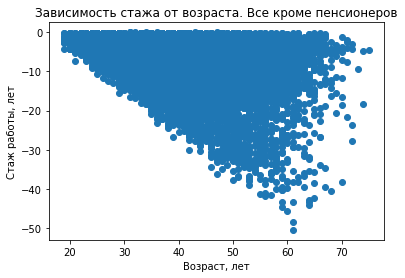

In [77]:
fig, ax = plt.subplots()
ax.scatter(
    retiree_non_df['dob_years'],
    retiree_non_df['years_employed'],
)
ax.set_title("Зависимость стажа от возраста. Все кроме пенсионеров")
ax.set_xlabel('Возраст, лет') 
ax.set_ylabel('Стаж работы, лет')
plt.show()

Первая часть гипотезы верна. С возратанием возрата, всё большое количество людей имеют более высокий стаж.

In [78]:
retiree_df = df[df['income_type'] == "пенсионер"][["dob_years", "days_employed"]]

In [79]:
retiree_df['years_employed'] = retiree_df['days_employed'] / 365

In [80]:
retiree_df = retiree_df.sort_values(by='dob_years')

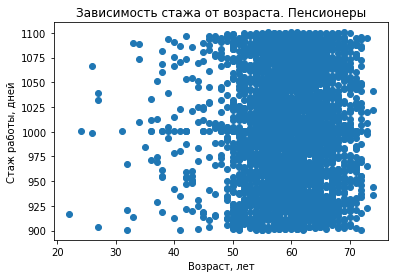

In [81]:
fig, ax = plt.subplots()
ax.scatter(
    retiree_df['dob_years'],
    retiree_df['years_employed'],
)
ax.set_title("Зависимость стажа от возраста. Пенсионеры")
ax.set_xlabel('Возраст, лет') 
ax.set_ylabel('Стаж работы, дней') 
plt.show()

Данные по пенсионерам вызывают сомнения. Срок стажа у всех пенсионеров превосходит **900 лет**.
Вероятнно, для них указывается другой показатель. Так как в целях проекта нет поиска зависимости между сроком стажа и возвращение кредита. Используем данные, но использовать стаж работы пенсионеров для других целей невозможно, без получения объяснения значений.

На этапе ознакомления с данными было отмечено, что данны в стоблце, описывающем семейное положение имеют различный регистр. Приведем все данные к нижнему регистру

In [82]:
df.family_status = df.family_status.str.lower()

In [83]:
df.family_status.value_counts()

женат / замужем          12240
гражданский брак          4134
не женат / не замужем     2781
в разводе                 1178
вдовец / вдова             947
Name: family_status, dtype: int64

Данные приведены к нижнему регистру

### Шаг 2.3. Удаление дубликатов.

В ходе обзора данных были обнаружены явные и неявные повторы. Неявные повторы были утилизированы в процессе предобработки данных.
Удалим явные повторы

In [84]:
df.duplicated().sum()

71

In [85]:
df = df.drop_duplicates().reset_index(drop=True)

In [86]:
df.duplicated().sum()

0

Явные повторы удалены

### Шаг 2.4. Изменение типов данных.

Взглянем на типы данных.

In [87]:
df.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

Типы данных адекватных. Для более быстрой работы можно перевести некоторые объектные данные в категориальный тип, а численные привести к удобному формату.

In [88]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [89]:
list_col_category_data = [
    'children', 'education', 'education_id',
    'family_status', 'family_status_id', 
    'gender', 'income_type',
]
for col in list_col_category_data:
    df[col] = df[col].astype('category')

In [90]:
list_col_numeric_data = [
    'days_employed', 'dob_years', 'total_income',
]
for col in list_col_numeric_data:
    df[col] = pd.to_numeric(df[col])

In [91]:
df.total_income = df.total_income.astype('int')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21209 entries, 0 to 21208
Data columns (total 12 columns):
children            21209 non-null category
days_employed       21209 non-null float64
dob_years           21209 non-null int64
education           21209 non-null category
education_id        21209 non-null category
family_status       21209 non-null category
family_status_id    21209 non-null category
gender              21209 non-null category
income_type         21209 non-null category
debt                21209 non-null int64
total_income        21209 non-null int64
purpose             21209 non-null object
dtypes: category(7), float64(1), int64(3), object(1)
memory usage: 974.8+ KB


### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Создадим два датасета-словаря, определяющих семейное положение и образование.

In [93]:
df_family = (df[['family_status', 'family_status_id']]
             .drop_duplicates()
             .reset_index(drop=True)
            )
df_education = (df[['education', 'education_id']]
                .drop_duplicates()
                .reset_index(drop=True)
               )

In [94]:
df = df.drop(['family_status', 'education'], axis=1)

Данные декомпозированы

### Шаг 2.6. Категоризация дохода.

Проведем категоризацию дохода по предложенным группам

    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'.

Опишем функцию категоризующие наши данные

In [95]:
def categorization_income(value: int) -> str:
    """
    Функция возращает категорию дохода по следующим правилам:
    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'.
    """
    list_diapason = [
        [0, 30_000, 'E'],
        [30_001, 50_000, 'D'],
        [50_001, 200_000, 'C'],
        [200_001, 1_000_000, 'B'],
        [1_000_001, float("inf"), 'A'],
    ]
    for diapason in list_diapason:
        if diapason[0] < value and diapason[1] > value:
            return diapason[2]

In [96]:
def test_function(value: int, res: str, function) -> None:
    assert function(value) == res, f'Функция выводит некоррктное значение. {value} {res}'
    print('Верное решение!')
    

In [97]:
list_test = [
    [2, 'E'],
    [45_000, 'D'],
    [70_000, 'C'],
    [300_000, 'B'],
    [2_0000_000_0000, 'A'],
]
for test_data in list_test:
    test_function(test_data[0], test_data[1], categorization_income)

Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!


In [98]:
df['total_income_category'] = df['total_income'].apply(categorization_income)

In [99]:
df['total_income_category'] = df['total_income_category'].astype('category')

Данные по доходам категоризированы!

### Шаг 2.7. Категоризация целей кредита.

Проведем категоризацию целей по предложенным группам

* операции с автомобилем
* операции с недвижимостью
* проведение свадьбы
* получение образования

Опишем функцию категоризующие наши данные


In [100]:
def categorusation_purpose(purpose: str) -> str:
    """
    Категоризация данных по целям на следующие группы:
        
    операции с автомобилем
    операции с недвижимостью
    проведение свадьбы
    получение образования

    """
    purpose = purpose.lower()
    if "жил" in purpose or "недвиж" in purpose:
        return "операции с недвижимостью"
    elif  "авто" in purpose:
        return "операции с автомобилем"
    elif "свадьб" in purpose or "свадеб" in purpose:
        return "проведение свадьбы"
    elif "образ" in purpose:
        return "получение образования"
    

In [101]:
test_data_purpose = [
    ['приобретение автомобиля', "операции с автомобилем"],
    ['на покупку подержанного автомобиля', "операции с автомобилем"],
    ['автомобили', "операции с автомобилем"],
    ['покупка жилья', "операции с недвижимостью"],
    ['покупка коммерческой недвижимости', "операции с недвижимостью"],
    ['покупка жилой недвижимости', "операции с недвижимостью"],
    ['на проведение свадьбы', "проведение свадьбы"],
    ['свадьба', "проведение свадьбы"],
    ['свадебное путешествие', "проведение свадьбы"],
    ['заняться высшим образованием', "получение образования"],
    ['получение образования', "получение образования"],
    ['получение дополнительного образования', "получение образования"],
    
]

In [102]:
for test in test_data_purpose:
    test_function(test[0], test[1], categorusation_purpose)

Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!
Верное решение!


In [103]:
df['purpose_category'] = df['purpose'].apply(categorusation_purpose)

In [104]:
df['purpose_category'] = df['purpose_category'].astype('category')

Данные по целям категоризованы.

### Ответы на вопросы.

##### Вопрос 1:     Есть ли зависимость между количеством детей и возвратом кредита в срок?


Посчитаем среднее(в этом случае частоту) невозвратов кредита в зависимости от количества детей.

In [105]:
res_children = df.pivot_table(index='children', values='debt', aggfunc='mean')*100
res_children

,debt
children,
0,7.550132
1,9.185804
2,9.470069
3,8.256881
4,9.756098


Добавим данные по возрасту и доходу

In [106]:
res_age_children = (df.pivot_table(
    index='children',
    values='dob_years',
    aggfunc='mean')
)
res_age_children

,dob_years
children,
0,46.460216
1,38.504384
2,35.996075
3,36.510703
4,36.048780


In [107]:
res_income_children = (df.pivot_table(
    index='children',
    values='total_income',
    aggfunc='mean')
)
res_income_children

,total_income
children,
0,163038.075216
1,169270.999165
2,169747.447007
3,180014.110092
4,166363.097561


In [108]:
res_pt_children = res_children.merge(
    res_age_children,
    on='children'
).merge(
    res_income_children,
    on='children'
).sort_values(
    by='children'
).reset_index()
res_pt_children['children'] = res_pt_children['children'].astype('int')
res_pt_children

,children,debt,dob_years,total_income
0,0,7.550132,46.460216,163038.075216
1,1,9.185804,38.504384,169270.999165
2,2,9.470069,35.996075,169747.447007
3,3,8.256881,36.510703,180014.110092
4,4,9.756098,36.048780,166363.097561


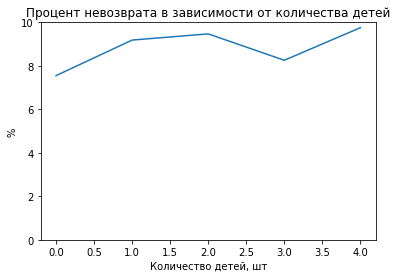

In [109]:
fig, ax = plt.subplots()
ax.plot(
    res_pt_children['children'],
    res_pt_children['debt']
)
ax.set_title("Процент невозврата в зависимости от количества детей")
plt.ylim(0,10)
ax.set_xlabel('Количество детей, шт') 
ax.set_ylabel('%')
plt.show()

##### Вывод 1:

Чёткой зависимости невозратов кредитов от **количества детей** не наблюдается. Вне зависимости от количества детей, процент невозратов составляет от 7% до 10%. Но наблюдается тенденция к повышению невозратов при увеличении количества детей.

##### Вопрос 2:  Есть ли зависимость между семейным положением и возвратом кредита в срок?

Сгруппируем данные по семеному статусу и применим функцию усреднения. Умножим на сто. В результате, процент невозратов в каждой группе.

In [110]:
res_pt_family = df.pivot_table(index='family_status_id', values='debt', aggfunc='mean')*100

In [111]:
res_pt_family = res_pt_family.merge(df_family, on='family_status_id')
res_pt_family

,family_status_id,debt,family_status
0,0,7.549799,женат / замужем
1,1,9.323272,гражданский брак
2,2,6.553911,вдовец / вдова
3,3,7.130730,в разводе
4,4,9.791217,не женат / не замужем


Проверим, связь статуса с возрастом и средним доходом

In [112]:
res_age = (df.pivot_table(
    index='family_status_id',
    values='dob_years',
    aggfunc='mean')
)
res_age

,dob_years
family_status_id,
0,43.728666
1,42.291870
2,56.800211
3,45.955857
4,38.592513


In [113]:
res_income = (df.pivot_table(
    index='family_status_id',
    values='total_income',
    aggfunc='mean')
)
res_income

,total_income
family_status_id,
0,166755.125256
1,164791.111490
2,142708.173362
3,168100.091681
4,166616.246580


In [114]:
res_pt_family = res_pt_family.merge(
    res_age,
    on='family_status_id'
).sort_values(
    by='dob_years'
).merge(
    res_income,
    on='family_status_id'
)
res_pt_family

,family_status_id,debt,family_status,dob_years,total_income
0,4,9.791217,не женат / не замужем,38.592513,166616.246580
1,1,9.323272,гражданский брак,42.291870,164791.111490
2,0,7.549799,женат / замужем,43.728666,166755.125256
3,3,7.130730,в разводе,45.955857,168100.091681
4,2,6.553911,вдовец / вдова,56.800211,142708.173362


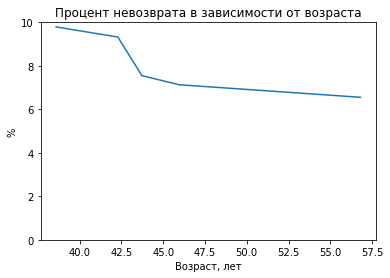

In [115]:
fig, ax = plt.subplots()
ax.plot(
    res_pt_family['dob_years'],
    res_pt_family['debt'],
)
ax.set_title("Процент невозврата в зависимости от возраста")
plt.ylim(0,10)
ax.set_xlabel('Возраст, лет') 
ax.set_ylabel('%')
plt.show()

##### Вывод 2:

Чёткой зависимости невозратов кредитов от **семейного статуса** не наблюдается. Вне зависимости от статуса, процент невозратов составляет от 6% до 10%. У людей бывших или состоящих **в оффициальных отношения**, невозрат кредитов **меньше** и составляет до 7,5%, в то время как у людей без оффициальных отношений невозратов больше. Вероятно, это связано, так же с более низким возраcтом людей в этиъ группах. Поэтому, вероятно, что существует зависимость между невозратом и возратом. **С возрастанием возраста возрастает и процент невозврата.**

#####  Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Сгруппируем данные по уровню дохода и применим функцию усреднения. Умножим на сто. В результате, процент невозратов в каждой группе.

In [116]:
df.pivot_table(index='total_income_category', values='debt', aggfunc='mean')*100

,debt
total_income_category,
A,8.000000
B,7.092626
C,8.485920
D,6.069364
E,9.090909


##### Вывод 3:

Чёткой зависимости невозратов кредитов от **уровня дохода** не наблюдается. Вне зависимости от дохода, процент невозратов составляет от 6% до 9%.

#####  Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

Сгруппируем данные по уровню дохода и применим функцию усреднения. Умножим на сто. В результате, процент невозратов в каждой группе.

In [117]:
df.pivot_table(index='purpose_category', values='debt', aggfunc='mean')*100

,debt
purpose_category,
операции с автомобилем,9.306698
операции с недвижимостью,7.259800
получение образования,9.299395
проведение свадьбы,7.879843


##### Вывод 4:

з анализа видно, что **операции с автомобилем** и **получение образования** чаще (около 9,3%) невозращают кредиты по сравнению с целями связанными с **операциями с недвижимостью** и **проведением свадьбы**

#### Проверим связь выделеных признаков

Сгруппируем данные по выделеным ранее категориям

In [118]:
df = df.merge(df_family, on='family_status_id')

In [119]:
(df
 .pivot_table(
     index=['family_status','purpose_category'],
     values ='debt',
     aggfunc='mean')
 .sort_values(by='debt', ascending=False)
)

debt
family_status         purpose_category                  
гражданский брак      получение образования     0.149254
не женат / не замужем операции с автомобилем    0.129747
гражданский брак      операции с автомобилем    0.119438
не женат / не замужем получение образования     0.108581
гражданский брак      операции с недвижимостью  0.092668
вдовец / вдова        операции с автомобилем    0.087963
женат / замужем       получение образования     0.083919
                      операции с автомобилем    0.082470
не женат / не замужем операции с недвижимостью  0.081270
гражданский брак      проведение свадьбы        0.078798
вдовец / вдова        получение образования     0.076531
в разводе             операции с автомобилем    0.076087
                      получение образования     0.071730
женат / замужем       операции с недвижимостью  0.069667
в разводе             операции с недвижимостью  0.069173
вдовец / вдова        операции с недвижимостью  0.052434

Как видим, больше значение оказывает цель. Получени образования и операции с автомобилем, лидируют в рейтенге невозрата. Причём семейное положение не оказывает существенного влияния.

Как видим, наименьшая встречаемость просрочек у людей имеющих/имевших семью и среди целей для кредита фигурирует операция с недвижимостью.

## Общий вывод:

Исходя из полученных данных можно предположить, что **наиболее важными для формулирования критериев** возврата кредитных средств являются следующие показатели:
* Цели кредита. Так кредиты на **операции с автомобилем и образованием на 2% чаще не вовращаются в банк вовремя**. Этот показатель стоит учитывать при выдачи кредита.
* Показатели дохода, количества детей **не связаны четкой зависимостью** с процентом невозвратов кредита. Можно говорить о тенеденциях. 
** Так с повышением **количества детей** возможно будет увеличиваться количество невозратов. Но на данных имеющихся в этом датасете **нельзя говорить о чёткой связи**.
** Уровень дохода имеет **разнонаправленню динамику**. Так группы с доходами 30 000 - 50 000 и 200 000 - 1 000 000 чаще вовращают кредиты, чем представители остальных групп. Возможно, это связано с различными целями и ценами за желаемую продукцию. Но **эта гипотеза, требует дополнительного исследования**.
* Семейное положени показывает связь с уровнем невозврата, но вероятно, эта связь опосредована возратом людей берущих кредиты. Так **с увеличением возраста уменьшается уровень невозврата кредита**. Вероятно, возраст также связан и с семейным положением, более молоды люди чаще не состоят в оффициальных отношения, по сравнению с людьми старшего возраста. Поэтому так же была обнаружена связь **если люди состоят/состояли в оффициальных отношениях, как правило возрастает процент возврата кредита**.

Поэтому основами для критериев выдачи кредитов являются: **цели кредитов, возраст и семейное положение**.